In [282]:
from os import path
import numpy as np

import astropy.coordinates as coord
import astropy.units as u

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

import numpy as np
import pandas as pd

In [2]:
data_path = '/Users/james/research/hack-days/AstroHackWeek2017/day1/data/ahw2017-ml-data/'

# Reading the Gaia TGAS data

The data are all stored in a single FITS binary table and can be read using the `astropy.table.Table` class:

In [3]:
tgas = Table.read(path.join(data_path, 'gaia', 'tgas_2mass_wise.fits'))

In [4]:
print(tgas.colnames)

['hip', 'tycho2_id', 'solution_id', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_good_obs_ac', 'astrometric_n_bad_obs_al', 'astrometric_n_bad_obs_ac', 'astrometric_delta_q', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_primary_flag', 'astrometric_relegation_factor', 'astrometric_weight_al', 'astrometric_weight_ac', 'astrometric_priors_used', 'matched_observations', 'duplicated_source', 'scan_direction_strength_k1', 'scan_direction_strength_k2', 'scan_direction_strength_k3', 'scan_direction_strength_k4', 'scan_direction_mean_k1', 'scan_direction_mean_k2', 'scan_direction_mean

In [12]:
TGAS = tgas.to_pandas()
# TGAS

---

As an example of using the data, let's make two color-magnitude diagrams for all stars within 150 pc:

In [5]:
with u.set_enabled_equivalencies(u.parallax()):
    dist = coord.Distance((tgas['parallax'] * u.mas).to(u.pc), 
                          allow_negative=True)
    
dist_cut = (dist < 500. * u.pc) & (dist > 0)

Compute absolute magnitude using the distance to each star, and compute colors by differencing magnitudes:

In [6]:
M_G = tgas['phot_g_mean_mag'][dist_cut] - dist[dist_cut].distmod.value
G_J = tgas['phot_g_mean_mag'][dist_cut] - tgas[dist_cut]['j_m']
G_W1 = tgas['phot_g_mean_mag'][dist_cut] - tgas[dist_cut]['w1mpro']

G_W2 = tgas['phot_g_mean_mag'][dist_cut] - tgas[dist_cut]['w2mpro']

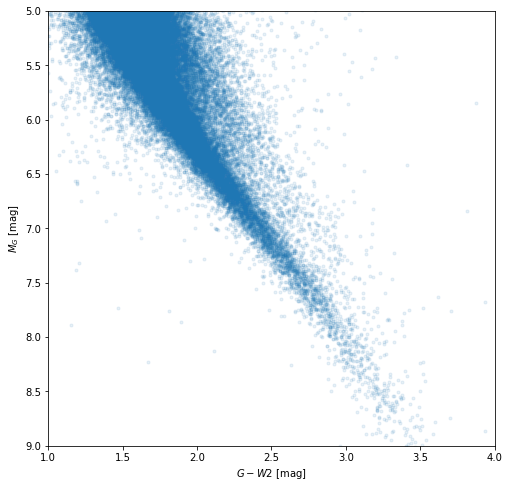

In [232]:
ok = np.where((M_G > 4) & (M_G < 9) & (G_W2 > 1) & (G_W2 < 4))

plt.figure(figsize=(8,8))
plt.scatter(G_W2, M_G, marker='.', alpha=0.1)
plt.xlim(1, 4)
plt.ylim(9, 5)
plt.xlabel('$G-W2$ [mag]')
plt.ylabel('$M_G$ [mag]')

## Brute Force: an isochrone grid

Let's explore this idea a little using a brute force approach, making use of isochrones to transform from observed magnitudes into physical units (i.e. masses)

In [15]:
# 2 files from Padova isochrone page
iso1 = pd.read_table('data/output303833828847.dat', delim_whitespace=True, comment='#', 
                     names=('Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 'C_O', 
                            'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 
                            'Z', 'mbolmag', 'Gmag', 'G_BPmag', 'G_RPmag'))

iso2 = pd.read_table('data/output555150325949.dat', delim_whitespace=True, comment='#', 
                     names=('Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 'C_O', 
                            'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 
                            'Z', 'mbolmag', 'Jmag', 'Hmag', 'Ksmag', 'IRAC_3.6mag', 'IRAC_4.5mag', 
                            'IRAC_5.8mag', 'IRAC_8.0mag', 'MIPS_24mag', 'MIPS_70mag', 'MIPS_160mag', 
                            'W1mag', 'W2mag', 'W3mag', 'W4mag'))


define the main sequence stars I'm interested in

In [96]:
ms = (iso1['label'] < 2) & (iso1['logg'] > 4) & (10**iso1['logTe'] <= 6000)

print(sum(ms))

36


4.608


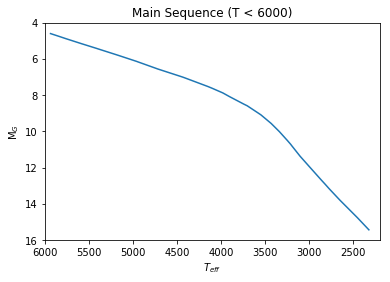

In [100]:
plt.plot(10**iso1['logTe'][ms], iso1['Gmag'][ms])
plt.xlabel('$T_{eff}$')
plt.ylabel('M$_G$')
plt.title("Main Sequence (T < 6000)")
plt.ylim(16,4);
plt.xlim(6000,2200);

print(iso1['Gmag'][ms].values[-1]) # the brightest star's G mag

remember how to do math with astronomy magnitudes!

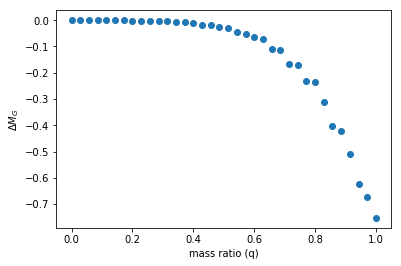

In [101]:
f_ratio = -2.5 * np.log10(1 + 10**(0.4 * (iso1['Gmag'][ms].values[-1] - iso1['Gmag'][ms].values)))
plt.plot(np.linspace(0,1,sum(ms)), f_ratio, 'o')

plt.xlabel('mass ratio (q)')
plt.ylabel('$\Delta M_G$')

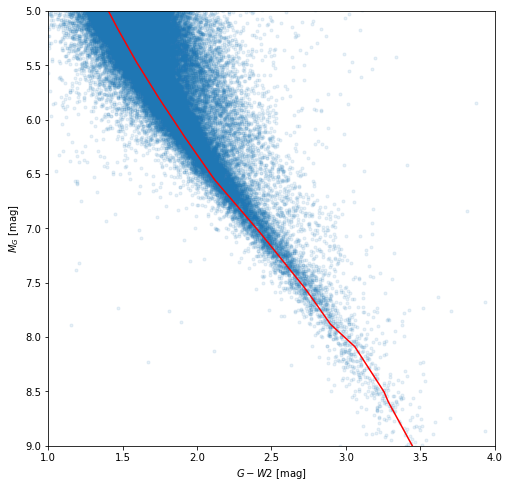

In [103]:
plt.figure(figsize=(8,8))
plt.scatter(G_W2, M_G, marker='.', alpha=0.1)
plt.plot(iso1['Gmag'][ms] - iso2['W2mag'][ms], iso1['Gmag'][ms], c='r')
plt.xlim(1, 4)
plt.ylim(9, 5)
plt.xlabel('$G-W2$ [mag]')
plt.ylabel('$M_G$ [mag]')


# The model goes through the data - GOOD!!

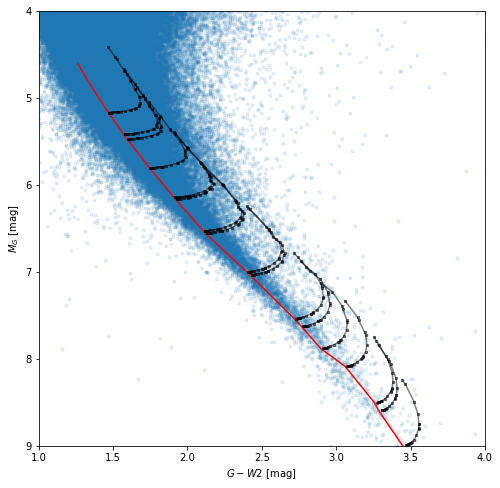

In [171]:
# make the grid of tracks for binary stars at 10 diff mass ratios

# then make LOTS of possible tracks for triple stars!

msTGAS = np.where((iso1['Gmag'][ms] >= 5) & 
                  (iso1['Gmag'][ms] <= 9))[0][::-1]

plt.figure(figsize=(8,8))
plt.scatter(G_W2, M_G, marker='.', alpha=0.1)
plt.plot(iso1['Gmag'][ms] - iso2['W2mag'][ms], iso1['Gmag'][ms], c='r')
plt.xlim(1, 4)
plt.ylim(9, 4)
plt.xlabel('$G-W2$ [mag]')
plt.ylabel('$M_G$ [mag]')

for k in range(len(msTGAS)):
    dG  = -2.5 * np.log10(1 + 10**(0.4 * (iso1['Gmag'][ms].values[msTGAS[k]] - 
                                          iso1['Gmag'][ms].values[0:msTGAS[k]+1])))
    dW2 = -2.5 * np.log10(1 + 10**(0.4 * (iso2['W2mag'][ms].values[msTGAS[k]] - 
                                          iso2['W2mag'][ms].values[0:msTGAS[k]+1])))
    plt.plot((iso1['Gmag'][ms].values[msTGAS[k]] + dG) - 
             (iso2['W2mag'][ms].values[msTGAS[k]] + dW2), 
             iso1['Gmag'][ms].values[msTGAS[k]] + dG, '-s', c='k', alpha=0.5, markersize=2)

So in principle, we could interpolate the isochrone onto a much finer grid in this space, and then figure out which point is closest for each star.... a truely (*horrible*) brute force approach

## Exploring triple star tracks

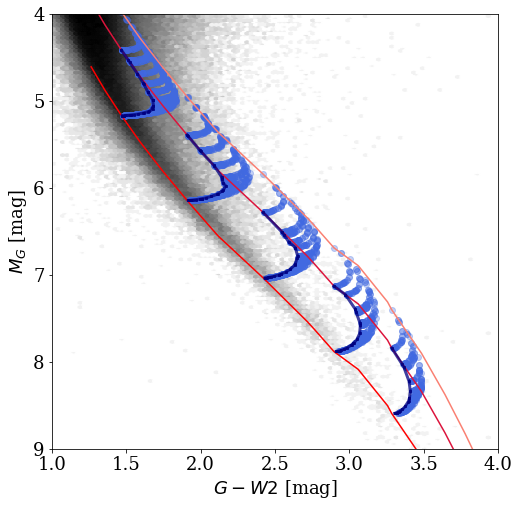

In [288]:
plt.figure(figsize=(8,8))

plt.hexbin(G_W2[ok], M_G[ok], cmap=plt.cm.Greys, bins='log', gridsize=(100,100))
plt.plot(iso1['Gmag'][ms] - iso2['W2mag'][ms], iso1['Gmag'][ms], c='r')

plt.plot(iso1['Gmag'][ms] - iso2['W2mag'][ms], iso1['Gmag'][ms] - 2.5*np.log10(2), c='Crimson')
plt.plot(iso1['Gmag'][ms] - iso2['W2mag'][ms], iso1['Gmag'][ms] - 2.5*np.log10(3), c='Salmon')

plt.xlim(1, 4)
plt.ylim(9, 4)
plt.xlabel('$G-W2$ [mag]')
plt.ylabel('$M_G$ [mag]')


Ntrack = np.array([0,4,9,12, 15])

for k in Ntrack:
    dG  = -2.5 * np.log10(1 + 10**(0.4 * (iso1['Gmag'][ms].values[msTGAS[k]] - 
                                          iso1['Gmag'][ms].values[0:msTGAS[k]+1])))
    dW2 = -2.5 * np.log10(1 + 10**(0.4 * (iso2['W2mag'][ms].values[msTGAS[k]] - 
                                          iso2['W2mag'][ms].values[0:msTGAS[k]+1])))
    plt.plot((iso1['Gmag'][ms].values[msTGAS[k]] + dG) - 
             (iso2['W2mag'][ms].values[msTGAS[k]] + dW2), 
             iso1['Gmag'][ms].values[msTGAS[k]] + dG, '-s', c='Navy', alpha=0.75, markersize=2, lw=3)


for k in Ntrack:
    f1G = 10**(-0.4 * iso1['Gmag'][ms].values[msTGAS[k]])
    f1W2 = 10**(-0.4 * iso2['W2mag'][ms].values[msTGAS[k]])
    
    f2G = 10**(-0.4 * iso1['Gmag'][ms].values[0:msTGAS[k]+1])
    f2W2 = 10**(-0.4 * iso2['W2mag'][ms].values[0:msTGAS[k]+1])
    
    for j in range(len(f2G)):
        dG = -2.5 * np.log10(f1G + f2G[j] + f2G) - iso1['Gmag'][ms].values[msTGAS[k]]
        dW2 = -2.5 * np.log10(f1W2 + f2W2[j] + f2W2) - iso2['W2mag'][ms].values[msTGAS[k]]
        
        plt.scatter((iso1['Gmag'][ms].values[msTGAS[k]] + dG) - 
                 (iso2['W2mag'][ms].values[msTGAS[k]] + dW2), 
                 iso1['Gmag'][ms].values[msTGAS[k]] + dG, alpha=0.3, c='RoyalBlue')
plt.savefig('CMD_triple.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

## Now up-sample the isochrone!

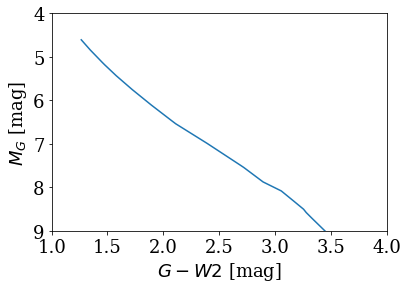

In [291]:
Mbins = 1000
mass = np.linspace(np.nanmin(iso1['Mass'][ms]), np.nanmax(iso1['Mass'][ms]), Mbins)
msort = np.argsort(iso1['Mass'][ms])
# bands to up-sample: G,J,K,W1,W2

Gbig = np.interp(mass, iso1['Mass'][ms].values[msort], iso1['Gmag'][ms].values[msort])
Jbig = np.interp(mass, iso1['Mass'][ms].values[msort], iso2['Jmag'][ms].values[msort])
Kbig = np.interp(mass, iso1['Mass'][ms].values[msort], iso2['Ksmag'][ms].values[msort])
W1big = np.interp(mass, iso1['Mass'][ms].values[msort], iso2['W1mag'][ms].values[msort])
W2big = np.interp(mass, iso1['Mass'][ms].values[msort], iso2['W2mag'][ms].values[msort])

f1G = 10**(-0.4 * Gbig)
f1J = 10**(-0.4 * Jbig)
f1K = 10**(-0.4 * Kbig)
f1W1 = 10**(-0.4 * W1big)
f1W2 = 10**(-0.4 * W2big)

plt.plot(Gbig - W2big, Gbig)
plt.xlim(1, 4)
plt.ylim(9, 4)
plt.xlabel('$G-W2$ [mag]')
plt.ylabel('$M_G$ [mag]')

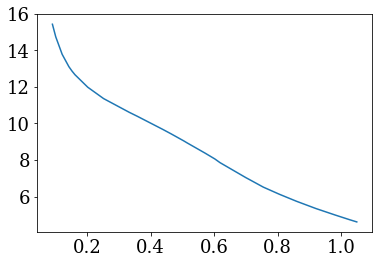

In [292]:
plt.plot(mass, Gbig)

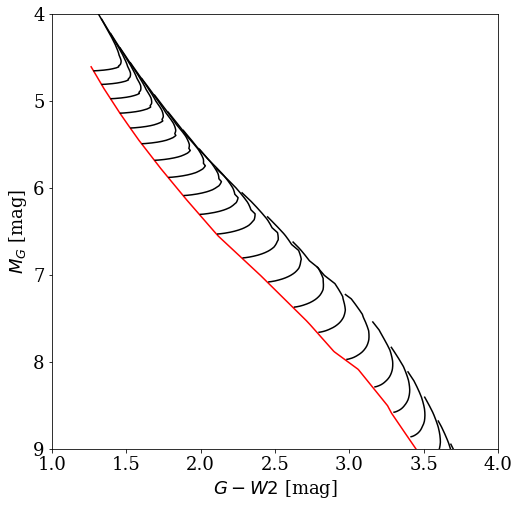

In [295]:
plt.figure(figsize=(8,8))
# plt.scatter(G_W2, M_G, marker='.', alpha=0.1)
plt.plot(Gbig - W2big, Gbig, c='r')

for k in range(0,1000,30):
    dG = -2.5 * np.log10(f1G[k] + f1G[0:k]) - Gbig[k]
    dW1 = -2.5 * np.log10(f1W1[k] + f1W1[0:k]) - W1big[k]
    dW2 = -2.5 * np.log10(f1W2[k] + f1W2[0:k]) - W2big[k]
       
    plt.plot((Gbig[k] + dG) - (W2big[k] + dW2), (Gbig[k] + dG), c='k')

plt.xlim(1, 4)
plt.ylim(9, 4)
plt.xlabel('$G-W2$ [mag]')
plt.ylabel('$M_G$ [mag]')
plt.savefig('CMD_example1.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

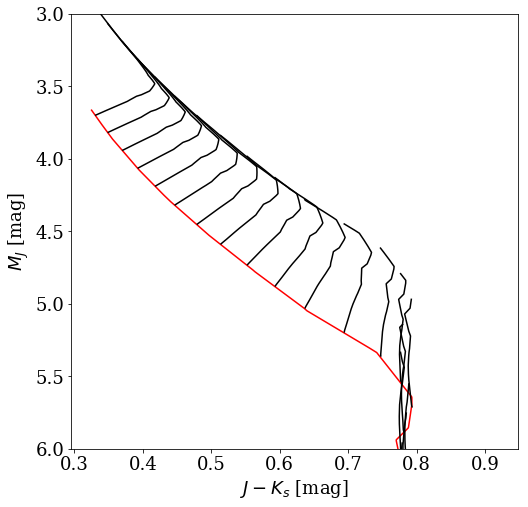

In [287]:
plt.figure(figsize=(8,8))
plt.plot(Jbig - Kbig, Jbig, c='r')

for k in range(0,1000,30):
    dJ = -2.5 * np.log10(f1J[k] + f1J[0:k]) - Jbig[k]
    dK = -2.5 * np.log10(f1K[k] + f1K[0:k]) - Kbig[k]
       
    plt.plot((Jbig[k] + dJ) - (Kbig[k] + dK), (Jbig[k] + dJ), c='k')

# plt.xlim(1, 4)
plt.ylim(6, 3)
plt.xlabel('$J - K_s$ [mag]')
plt.ylabel('$M_J$ [mag]')
plt.savefig('CMD_example2.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [265]:
xx = np.array([])
yy = np.array([])

# for k in range(0,1000,100):
for k in range(Mbins):
    dG = -2.5 * np.log10(f1G[k] + f1G[0:k]) - Gbig[k]
    dW1 = -2.5 * np.log10(f1W1[k] + f1W1[0:k]) - W1big[k]
    dW2 = -2.5 * np.log10(f1W2[k] + f1W2[0:k]) - W2big[k]
    
    xx = np.concatenate([xx, (Gbig[k] + dG) - (W2big[k] + dW2)])
    yy = np.concatenate([yy, (Gbig[k] + dG)])


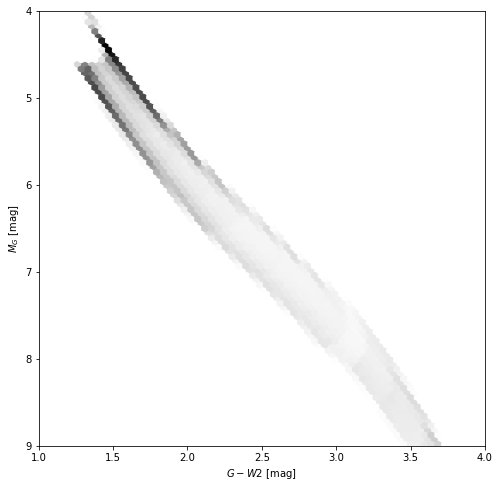

In [267]:
plt.figure(figsize=(8,8))
plt.hexbin(xx,yy, cmap=plt.cm.Greys, gridsize=(100,100))
plt.xlim(1, 4)
plt.ylim(9, 4)
plt.xlabel('$G-W2$ [mag]')
plt.ylabel('$M_G$ [mag]')